# Characterizing Patronage on YouTube

## 0. Files and brief explanation of those

All data is located in `/dlabdata1/youtube_large/`

In [1]:
DATA_FOLDER = "/dlabdata1/youtube_large/"

**YouNiverse dataset:**

- `df_channels_en.tsv.gz`: channel metadata.
- `df_timeseries_en.tsv.gz`: channel-level time-series.
- `yt_metadata_en.jsonl.gz`: raw video metadata.
- `youtube_comments.tsv.gz`: user-comment matrices.
- `youtube_comments.ndjson.zst`: raw comments — this is a HUGE file.

**Graphteon dataset:**
- `creators.csv` list with all creator names.
- `final_processed_file.jsonl.gz` all graphteon time-series.
- `pages.zip` raw html of the pages in graphteon.

#### Libaries imports

In [2]:
# !conda list

In [3]:
import os 
import io
import pandas as pd
import json
import re
import zstandard
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import gzip
from tqdm import tqdm
import timeit
import ast

In [4]:
# list all files in current directory
!ls -lh

total 1.1G
-rw-r--r-- 1 fmurray IN-MA4_StudU 334M Mar 26 20:57 df_gt_timeseries_filtered.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU  68K Apr  1 16:29 patronage_youtube.ipynb
-rw-r--r-- 1 fmurray IN-MA4_StudU  818 Feb 28 15:34 README.md
drwxr-xr-x 3 fmurray IN-MA4_StudU 4.0K Mar 26 21:00 scripts
-rw-r--r-- 1 fmurray IN-MA4_StudU 241K Mar 25 19:22 yt_metadata_en_pt_TEST.tsv.gz
-rw-r--r-- 1 fmurray IN-MA4_StudU 740M Mar 26 17:19 yt_metadata_en_pt.tsv.gz


In [5]:
# list all files in DATA_FOLDER
!ls -lh /dlabdata1/youtube_large

total 836G
-rw-r--r--  1 horta   dlab_AppGrpU  13M Feb 21 09:22 creators.csv
-rw-r--r--  1 horta   dlab_AppGrpU 5.7M Dec 18  2020 df_channels_en.tsv.gz
-rw-r--r--  1 horta   dlab_AppGrpU 545M Dec 16  2020 df_timeseries_en.tsv.gz
-rw-r--r--  1 horta   dlab_AppGrpU 2.7G Feb 21 09:29 final_processed_file.jsonl.gz
-rw-r--r--  1 horta   dlab_AppGrpU 605K Dec 16  2020 invalid.csv
drwxr-sr-x 10 jouven  dlab_AppGrpU 4.0K Jan 15  2021 jouven
-rw-r--r--  1 horta   dlab_AppGrpU 1.3G Mar 30  2021 num_comments_authors.tsv.gz
-rw-r--r--  1 horta   dlab_AppGrpU 720M Mar 30  2021 num_comments.tsv.gz
drwxr-sr-x  4 olam    dlab_AppGrpU 4.0K Nov  1  2020 olam
-rw-r--r--  1 horta   dlab_AppGrpU 4.4G Feb 21 09:41 pages.zip
-rw-r--r--  1 horta   dlab_AppGrpU 6.2M Dec 16  2020 _raw_df_channels.tsv.gz
-rw-r--r--  1 horta   dlab_AppGrpU 623M Dec 16  2020 _raw_df_timeseries.tsv.gz
-rwxrwxrwx  1 horta   dlab_AppGrpU  14G Jul 21  2020 _raw_yt_metadata.jsonl.zst
-rw-r--r--  1 horta   dlab_AppGrpU 7.9K Dec 18  2020

## 1. Exploratory Data Analysis (EDA)

### 1.1. YouNiverse dataset

#### 1.1.1 Channel metadata
Metadata associated with the 136,470 channels: **channel ID**, **join date**, **country**, **number of subscribers**, **most frequent category**, and the **channel’s position** in socialblade.com’s subscriber ranking. \
The number of subscribers is provided both as obtained from channelcrawler.com (between 2019-09-12 and 2019-09-17) and as crawled from socialblade.com (2019-09-27). Additionally, we also provide a set of **weights** (derived from socialblade.com’s subscriber rankings) that can be used to partially correct sample biases in our dataset.

- `category_cc`: category of the channel (majority based)
- `join_date`: join date of the channel
- `channel`: channel id
- `name_cc`: name of the channel.
- `subscribers_cc`: number of subscribers
- `videos_cc`: number of videos
- `subscriber_rank_sb`: rank in terms of number of subscribers (channel’s position in socialblade.com’s subscriber ranking)
- `weights`: weights cal (Set of weights derived from socialblade.com’s subscriber rankings. Can be used to partially correct sample biases in our dataset. -> correction for representation)

In [ ]:
# !ls -lh /dlabdata1/youtube_large/df_channels_en.tsv.gz

In [ ]:
# channel metadata
df_yt_channels = pd.read_csv(DATA_FOLDER+'df_channels_en.tsv.gz', sep="\t", compression='gzip')
df_yt_channels

Facts about this data (taken from [YouNiverse github page](https://github.com/epfl-dlab/YouNiverse)) 

- This dataframe has 136,470 rows, where each one corresponds to a different channel.
- We obtained all channels with >10k subscribers and >10 videos from channelcrawler.com in the 27 October 2019.
- Additionally we filtered all channels that were not in english given their video metadata (see `Raw Channels').

##### Summary statistics

In [ ]:
print('Number of unique categories:         {:,}'.format(df_yt_channels['category_cc'].nunique()))
print('Number of unique channels:      {:,}'.format(df_yt_channels['channel'].nunique()))
print('Number of unique channel names: {:,}'.format(df_yt_channels['name_cc'].nunique()))

print('\nNote: there are more unique channels than unique names, so some channels might have the same name!')

##### Distribution of videos and subscribers per channel

In [ ]:
selected_cols = ['videos_cc', 'subscribers_cc']

# plot with linear scale for x axis and log scale for y axis
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=df_yt_channels[col], ax=ax, bins=50, kde=False, color=f'C{i}')
    ax.set(title=f'Distribution of {col}')
    ax.set_ylabel("Count - number of channels (log scale)")
    ax.set(yscale="log")
    # ax.set(xscale="log")
plt.tight_layout()
plt.show()


# plot with log scale for x axis 
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

xlabels = [r'$\log_{10}(videos)$', r'$\log_{10}(subscribers)$']

for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
    sns.histplot(data=np.log10(df_yt_channels[col]), ax=ax, bins=50, kde=False, cumulative=False, color=f'C{i}')

    ax.set(title=f'Distribution of {col} (log-log scale)')
    ax.set_xlabel(xlabels[i])
    ax.set_ylabel("Count - number of channels")

    # ax.set(yscale="log")
    # ax.set(xscale="log")
plt.tight_layout()
plt.show()


# plot with linear scale for both axes 
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
#     sns.histplot(data=df_yt_channels[col], ax=ax, bins=50, kde=False, color=f'C{i}')
#     ax.set(title=f'Distribution of {col}')
#     ax.set_ylabel("Count - number of channels")
#     # ax.set(yscale="log")
#     ax.set(xscale="log")
# plt.tight_layout()
# plt.show()

# # plot with log scale for x axis (distplot)
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# for i,(col,ax) in enumerate(zip(selected_cols, axs.flatten())):
#     sns.distplot(np.log10(df_yt_channels[col]), hist_kws=kwargs, kde=False, kde_kws=kwargs, ax=ax, norm_hist=True)

#     ax.set(title=f'Distribution of {col} (log-log scale)')
#     ax.set_ylabel("Count - number of channels")
#     # ax.set(yscale="log")
#     # ax.set(xscale="log")
# plt.tight_layout()
# plt.show()


# descriptive statistics table
df_yt_channels[selected_cols].describe().T

**Discussion:** \
From the above graphs and table, we can see that _videos_ and _subscribers_ distributions among YouTube channels follow a **power law**, meaning that most channels have a only a few videos and a few subscribers, but a few of them have a lot of videos and a lot of subscribers.

More specifically:
- 50% of the YouTube channels have less than 175 videos
- 50% of the YouTube channels have less than 42,400 subscribers

_Note: only channels with at least 10 videos and 10,000 subscribers were considered for this study._

##### Group by categories

In [ ]:
data_per_cat_chan = df_yt_channels.groupby(['category_cc', 'channel'])[['videos_cc', 'subscribers_cc']].agg(['max'])

# set the columns to the top level of the multi-index
data_per_cat_chan.columns = data_per_cat_chan.columns.get_level_values(0)
data_per_cat_chan

In [ ]:
data_per_cat_chan.reset_index(inplace=True)
data_per_cat_chan

##### Number of channels per category

In [ ]:
chan_per_cat = data_per_cat_chan.groupby('category_cc')[['channel']].count().sort_values('channel', ascending=False)

In [ ]:
chan_per_cat.plot(kind='bar')
plt.title("Number of channels per category")
plt.xlabel("Categories")
plt.ylabel("Number of channels")
plt.show()
chan_per_cat['channel']

In [ ]:
# data_per_cat = data_per_cat_chan.groupby('category')['videos_cc','subscribers_cc'].agg(['min', 'max', 'count', 'sum'])
data_per_cat = data_per_cat_chan.groupby('category_cc')[['videos_cc','subscribers_cc']].agg(['sum'])
data_per_cat.columns = data_per_cat.columns.get_level_values(0)
data_per_cat = data_per_cat.add_suffix('_sum')
data_per_cat

##### Number of videos per category

In [ ]:
data_per_cat['videos_cc_sum'].sort_values(ascending=False).plot(kind='bar')
plt.title("Number of videos per category")
plt.xlabel("Categories")
plt.ylabel("Number of videos")
plt.show()

data_per_cat['videos_cc_sum'].sort_values(ascending=False)

##### Number of subscribers per category

In [ ]:
data_per_cat['subscribers_cc_sum'].sort_values(ascending=False).plot(kind='bar')
plt.title("Number of subscribers per category")
plt.xlabel("Categories")
plt.ylabel("Number of videos")
plt.show()

data_per_cat['subscribers_cc_sum'].sort_values(ascending=False)

#### 1.1.2 Channel time-series data
Weekly number of viewers and subscribers. We have a data point for each channel and each week.

Time series of channel activity at **weekly granularity**. The span of time series varies by channel depending on when socialblade.com started tracking the channel. On average, it contains **2.8 years of data per channel** for **133k channels** (notice that this means there are roughly 4k channels for which there is no time-series data). \
Each data point includes the **number of views** (`views`) and **subscribers** (`subs`) obtained in the given week, as well as the **number of videos** (`videos`) posted by the **channel** (`channel`). The number of videos is calculated using the video upload dates in our video metadata, such that videos that were unavailable at crawl time are not accounted for. 

---

Time series related to each channel.\
These come from a mix of YouTube data and time series crawled from [socialblade.com](https://socialblade.com/):
- From the former (YouTube data): derived weekly time series indicating **how many videos each channel had posted per week**. 
- From the latter (socialblade.com): crawled weekly statistics on the **number of viewers** `views` and **subscribers** `subs` per channel `channel`. This data was available for around 153k channels.

    - `channel`: unique channel ID, which is the numbers and letters at the end of the URL.
    - `category`: category of the channel as assigned by [socialblade.com](https://socialblade.com/) according to the last 10 videos at time of crawl (categories organize channels and videos on YouTube and help creators, advertisers, and channel managers identify with content and audiences they wish to associate with).
    - `datetime`: First day of the week related to the data point
    - `views`: Total number of views the channel had this week.
    - `delta_views`: Delta views obtained this week (difference of nb of views between current and former week). (Interpolation)
    - `subs`: Total number of subscribers the channel had this week.
    - `delta_subs`: Delta subscribers obtained this week (difference of nb of subscribers between current and former week)
    - `videos`: Number of videos posted by the channel up to date
    - `delta_videos`:  Delta videos obtained this week (difference of number of videos posted by the channel between current and former week).
    - `activity`: Number of videos published in the last 15 days.
    
    
Note: Can view the channel by appending the channel id to the url, e.g.  https://www.youtube.com/channel/UCBJuEqXfXTdcPSbGO9qqn1g


In [6]:
!ls -lh /dlabdata1/youtube_large/df_timeseries_en.tsv.gz

-rw-r--r-- 1 horta dlab_AppGrpU 545M Dec 16  2020 /dlabdata1/youtube_large/df_timeseries_en.tsv.gz


In [7]:
# channel-level time-series.
df_yt_timeseries = pd.read_csv(DATA_FOLDER+'df_timeseries_en.tsv.gz', sep="\t", compression='gzip', parse_dates=['datetime'])
df_yt_timeseries

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0
...,...,...,...,...,...,...,...,...,...,...
18872494,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-02,6.012938e+06,232418.277778,61268.611111,1305.611111,278,2,10
18872495,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-09,6.244579e+06,231640.888889,62631.666667,1363.055556,287,9,13
18872496,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-16,6.480902e+06,236322.933333,64010.000000,1378.333333,294,7,16
18872497,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-23,6.745317e+06,264415.200000,65480.000000,1470.000000,301,7,15


##### Summary statistics

In [8]:
# df_yt_timeseries.describe().T

In [9]:
yt_ts_uniq_chan_cnt = df_yt_timeseries['channel'].nunique()

print('Timeseries data was gathered between {} and {}'.format(df_yt_timeseries['datetime'].min().strftime('%B %d, %Y'),
                                                         df_yt_timeseries['datetime'].max().strftime('%B %d, %Y')))
print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_yt_timeseries)))
data_points_dist = df_yt_timeseries['channel'].value_counts()
print('Average number of datapoints per channel:       {:>12.0f} weeks (≈{:,.1f} years)'.format(data_points_dist.mean(), data_points_dist.mean()/52))
print('Number of unique categories:                     {:>12,}'.format(df_yt_timeseries['category'].nunique()))
print('Number of unique channels:                       {:>12,}'.format(yt_ts_uniq_chan_cnt))

Timeseries data was gathered between January 05, 2015 and September 30, 2019
Total number of datapoints accross all channels:   18,872,499
Average number of datapoints per channel:                141 weeks (≈2.7 years)
Number of unique categories:                               15
Number of unique channels:                            133,516


##### Datetime points per channel

Not all channels timeseries start and end at the same time, therefore we have a different amount of datapoints for each channel

In [10]:
datetime_data = df_yt_timeseries.groupby('channel')['datetime'].agg(['min', 'max'])
datetime_data.head()

,min,max
channel,,
UC--24Q3_ZQeFmgJE-Um5QZQ,2016-08-01,2019-09-23 00:00:00
UC--2EbuIuBOGgGqPiJxi3rg,2016-06-27,2019-09-30 00:00:00
UC--3c8RqSfAqYBdDjIG3UNA,2019-02-25,2019-09-30 01:00:00
UC--3ozenTzry39-xMqAPQlw,2016-10-03,2019-09-30 00:00:00
UC--6E6EpybocdaNlPhvK_9A,2016-08-08,2019-09-30 00:00:00


In [11]:
# datetime_data.describe().T

##### Datetime points per year

In [12]:
yt_ts_year_cnt = df_yt_timeseries.groupby(df_yt_timeseries.datetime.dt.year).size()

Timeseries data was gathered between January 05, 2015 and September 30, 2019


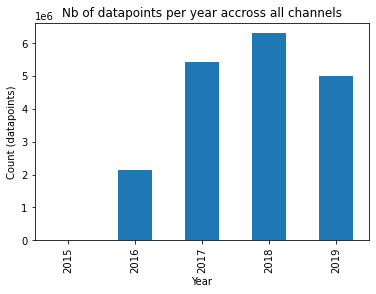

datetime
2015       2164
2016    2137720
2017    5434045
2018    6306258
2019    4992312
dtype: int64

In [13]:
print('Timeseries data was gathered between {} and {}'.format(df_yt_timeseries['datetime'].min().strftime('%B %d, %Y'),
                                                         df_yt_timeseries['datetime'].max().strftime('%B %d, %Y')))
yt_ts_year_cnt.plot(kind='bar')
plt.title("Nb of datapoints per year accross all channels")
plt.xlabel("Year")
plt.ylabel("Count (datapoints)")
plt.show()

yt_ts_year_cnt

##### Datetime points per month

In [14]:
yt_ts_month_cnt = df_yt_timeseries.groupby([df_yt_timeseries.datetime.dt.year, df_yt_timeseries.datetime.dt.month]).size()
yt_ts_month_cnt.head()

datetime  datetime
2015      1           22
          2           32
          3           58
          4           69
          5           77
dtype: int64

In [15]:
# using pandas.Grouper
yt_ts_month_cnt_grouper = df_yt_timeseries.groupby(pd.Grouper(key='datetime', freq='M')).count().channel
yt_ts_month_cnt_grouper.head()

datetime
2015-01-31    22
2015-02-28    32
2015-03-31    58
2015-04-30    69
2015-05-31    77
Freq: M, Name: channel, dtype: int64

In [ ]:
# plot number of datapoints per month
plt.figure(figsize=(15,2))
yt_ts_month_cnt.plot(kind='bar')
plt.title("Number of datapoints per month accross all channels (using regular group by method)")
plt.xlabel("Month")
plt.ylabel("Count (datapoints)")
plt.show()

# plot number of datapoints per month using grouper
plt.figure(figsize=(15,2))
yt_ts_month_cnt_grouper.plot(kind='bar')
plt.title("Number of datapoints per month accross all channels (using grouper)")
plt.xlabel("Month")
plt.ylabel("Count (datapoints)")
plt.show()

In [ ]:
# only consider unique values per channel
yt_ts_month_unique_cnt = df_yt_timeseries.groupby(pd.Grouper(key='datetime', freq='M')).agg({"channel": pd.Series.nunique})
yt_ts_month_unique_cnt.head()

In [ ]:
(df_yt_timeseries.groupby(['datetime', 'channel']).count() > 1).sum()

In [ ]:
# Number of channels with timeseries (only consider unique values per channel) --> see https://stackoverflow.com/questions/38309729/count-unique-values-per-groups-with-pandas

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month

fig, ax = plt.subplots(1, figsize=(7,3), sharey=True, sharex=True,
                       gridspec_kw={"wspace": 0.05})

ax.plot(yt_ts_month_unique_cnt)

ax.set(title='Number of channels with timeseries')
ax.set_xlabel("Month")
ax.set_ylabel("# channels")
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)

##### Datetime points accross channels

Total number of datapoints accross all channels:   18,872,499
Average number of datapoints per channel:                 141 weeks (≈2.7 years)


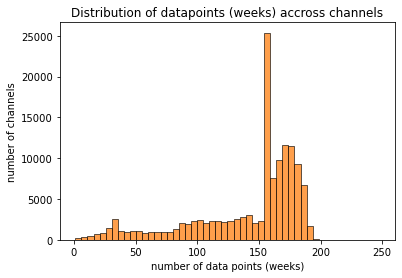

In [34]:
# Distribution of datapoints accross channels

print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_yt_timeseries)))
data_points_dist = df_yt_timeseries['channel'].value_counts()
print('Average number of datapoints per channel:        {:>12,.0f} weeks (≈{:,.1f} years)'.format(data_points_dist.mean(), data_points_dist.mean()/52))

ax = sns.histplot(data=data_points_dist, bins=50, kde=False, color=f'C{1}')

ax.set(title=f'Distribution of datapoints (weeks) accross channels')
ax.set_xlabel('number of data points (weeks)')
ax.set_ylabel('number of channels')

# ax.set(yscale="log")
# plt.tight_layout()
plt.show()

In [35]:
# Aggregates per channel
sel_cols = ['datetime', 'views', 'delta_views', 'subs', 'delta_subs', 'videos', 'delta_videos', 'activity']
data_per_channel = df_yt_timeseries.groupby('channel')[sel_cols].agg(['min', 'max', 'count', 'mean'])
data_per_channel.head()

datetime                            \
                                min                 max count   
channel                                                         
UC--24Q3_ZQeFmgJE-Um5QZQ 2016-08-01 2019-09-23 00:00:00   165   
UC--2EbuIuBOGgGqPiJxi3rg 2016-06-27 2019-09-30 00:00:00   171   
UC--3c8RqSfAqYBdDjIG3UNA 2019-02-25 2019-09-30 01:00:00    32   
UC--3ozenTzry39-xMqAPQlw 2016-10-03 2019-09-30 00:00:00   157   
UC--6E6EpybocdaNlPhvK_9A 2016-08-08 2019-09-30 00:00:00   165   

                                                               views  \
                                                  mean           min   
channel                                                                
UC--24Q3_ZQeFmgJE-Um5QZQ 2018-02-25 23:36:43.636363520  6.252450e+04   
UC--2EbuIuBOGgGqPiJxi3rg 2018-02-11 23:37:32.631578880  2.984862e+06   
UC--3c8RqSfAqYBdDjIG3UNA 2019-06-13 12:50:37.500000000  3.703988e+07   
UC--3ozenTzry39-xMqAPQlw 2018-04-01 23:35:32.484076544  7.669280e+06   
UC--6E6EpybocdaNlPhvK_9A 2018-03-04 23:36:43.636363520  1.900056e+06   

                                                           delta_views  \
                                   max count          mean         min   
channel                                                                  
UC--24Q3_ZQeFmgJE-Um5QZQ  4.356804e+06   165  1.365816e+06         0.0   
UC--2EbuIuBOGgGqPiJxi3rg  7.951972e+06   171  5.559505e+06         0.0   
UC--3c8RqSfAqYBdDjIG3UNA  5.798712e+07    32  4.707118e+07         0.0   
UC--3ozenTzry39-xMqAPQlw  1.455123e+07   157  1.223360e+07         0.0   
UC--6E6EpybocdaNlPhvK_9A  9.166274e+06   165  5.950502e+06         0.0   

                                        ... videos             delta_videos  \
                                   max  ...  count        mean          min   
channel                                 ...                                   
UC--24Q3_ZQeFmgJE-Um5QZQ  7.568855e+05  ...    165  108.236364            0   
UC--2EbuIuBOGgGqPiJxi3rg  6.411512e+04  ...    171   56.269006            0   
UC--3c8RqSfAqYBdDjIG3UNA  1.952233e+06  ...     32  302.968750            0   
UC--3ozenTzry39-xMqAPQlw  1.761543e+05  ...    157   38.159236            0   
UC--6E6EpybocdaNlPhvK_9A  1.181485e+05  ...    165   26.569697            0   

                                             activity                      
                         max count      mean      min max count      mean  
channel                                                                    
UC--24Q3_ZQeFmgJE-Um5QZQ   2   165  0.963636        1   3   165  1.957576  
UC--2EbuIuBOGgGqPiJxi3rg   1   171  0.070175        0   2   171  0.157895  
UC--3c8RqSfAqYBdDjIG3UNA   5    32  1.937500        0   8    32  3.875000  
UC--3ozenTzry39-xMqAPQlw   2   157  0.101911        0   3   157  0.235669  
UC--6E6EpybocdaNlPhvK_9A   1   165  0.060606        0   2   165  0.133333  

[5 rows x 32 columns]

#####  Views per channel

In [ ]:
data_per_channel['views'].head()

In [ ]:
# Distribution of total views per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

sns.histplot(data=data_per_channel['views']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')
axs[0].set(title=f'Distribution of total views per channel')
axs[0].set_xlabel('number of views (in billions)')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")
xlabels1 = ['{:,.0f}'.format(x) + 'bn' for x in axs[0].get_xticks()/1_000_000_000]
axs[0].set_xticklabels(xlabels1)

# Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['views']['max'], ax=axs[1], bins=1000, kde=False, color=f'C{1}')
axs[1].set(title=f'Distribution of total views per channel (log-log scale)')
axs[1].set_xlabel('number of views (in millions)')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")
xlabels2 = ['{:,.0f}'.format(x) + 'M' for x in axs[1].get_xticks()/1_000_000]
axs[1].set_xticklabels(xlabels2)

plt.tight_layout()
plt.show()

data_per_channel['views'][['max']].describe().T

In [ ]:
print("Top 10 channels with the most total views (in billions):")

for index, value in data_per_channel['views']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.1f} bn views'.format(index, value/1_000_000_000))

##### Videos per channel

In [ ]:
data_per_channel['videos'].head()

In [ ]:
# Distribution of total videos per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
sns.histplot(data=data_per_channel['videos']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')

axs[0].set(title=f'Distribution of total videos per channel')
axs[0].set_xlabel('number of videos')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")

# # Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['videos']['max'], ax=axs[1], bins=100, kde=False, color=f'C{1}')

axs[1].set(title=f'Distribution of total videos per channel (log-log scale)')
axs[1].set_xlabel('number of videos')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")

plt.tight_layout()
plt.show()

data_per_channel['videos'][['max']].describe().T

In [ ]:
print("Top 10 channels with the most total videos:")

for index, value in data_per_channel['videos']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.0f} videos'.format(index, value))

##### Subscribers per channel

In [ ]:
data_per_channel['subs'].head()

In [ ]:
# Distribution of total subscribers per channel
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
sns.histplot(data=data_per_channel['subs']['max'], ax=axs[0], bins=20, kde=False, color=f'C{1}')

axs[0].set(title=f'Distribution of total subscribers per channel')
axs[0].set_xlabel('number of subscribers (in millions)')
axs[0].set_ylabel('number of channels')
axs[0].set(yscale="log")
xlabels0 = ['{:,.0f}'.format(x) + 'M' for x in axs[0].get_xticks()/1_000_000]
axs[0].set_xticklabels(xlabels0)

# # Distribution of total views per channel (log scale)
sns.histplot(data=data_per_channel['subs']['max'], ax=axs[1], bins=500, kde=False, color=f'C{1}')

axs[1].set(title=f'Distribution of total subscribers per channel (log-log scale)')
axs[1].set_xlabel('number of subscribers')
axs[1].set_ylabel('number of channels')
axs[1].set(yscale="log")
axs[1].set(xscale="log")

plt.tight_layout()
plt.show()

data_per_channel['videos'][['max']].describe().T

In [ ]:
data_per_channel['subs']['max'].sort_values(ascending=False)[:10]

In [ ]:
print("Top 10 channels with the most total subscribers:")

for index, value in data_per_channel['subs']['max'].sort_values(ascending=False)[:10].items():
    print('https://www.youtube.com/channel/{} : {:,.1f}M subscribers'.format(index, value/1_000_000))

In [ ]:
# set the columns to the top level of the multi-index
# data_per_channel.columns = data_per_channel.columns.get_level_values(0)
# data_per_channel

#### 1.1.3 Raw video metadata
The file `df_videos_raw.jsonl.gz` contains metadata data related to ~73M videos from ~137k channels. Below we show the data recorded for each of the video

In [ ]:
!ls -lh /dlabdata1/youtube_large/yt_metadata_en.jsonl.gz

In [ ]:
# ! zcat /dlabdata1/youtube_large/yt_metadata_en.jsonl.gz | head

In [ ]:
df_yt_metadata = pd.read_json(DATA_FOLDER+'yt_metadata_en.jsonl.gz', compression='gzip', lines=True, nrows=2000)
df_yt_metadata.head(2)

#### 1.1.4 user-comment matrices

In [ ]:
# !ls -lh /dlabdata1/youtube_large/youtube_comments.tsv.gz

In [ ]:
# user-comment matrices
df_yt_comments = pd.read_csv(DATA_FOLDER+'youtube_comments.tsv.gz', sep="\t", compression='gzip', nrows=100)
df_yt_comments.head()

#### 1.1.5 raw comments

In [ ]:
# !ls -lh /dlabdata1/youtube_large/youtube_comments.ndjson.zst

In [ ]:
def line_jsonify(line): 
    """

    :param line: string to parse and jsonify
    :return: 
    """    
    
    # add square brackets around line
    line = "[" + line + "]"

    # remove quotes before and after square brackets   
    line = line.replace("\"[{", "[{")
    line = line.replace("}]\"", "}]")    
    
    # replace double double-quotes with single double-quotes
    line = line.replace("{\"\"", "{\"")
    line = line.replace("\"\"}", "\"}")
    line = line.replace("\"\":\"\"", "\":\"")
    line = line.replace(":\"\"", ":\"")
    line = line.replace("\"\":", "\":")
    
    # line = line.replace("\"\":", "\":")
    line = line.replace("\"\",\"\"", "\",\"")
    line = line.replace("\"\",\"\"", "\",\"")
    line = line.replace("\\\"\"", "\\\"")
    line = line.replace("\\\",[", "\\\\ \",[")
    
    line = re.sub(r',\"\"(?!\,)', ',\"', line)

    line = line.replace("true,\"\"", "true,\"")
    line = line.replace("false,\"\"", "false,\"")
    
    return line

In [ ]:
class Zreader:

    def __init__(self, file, chunk_size=16384):
        '''Init method'''
        import codecs
        self.fh = open(file,'rb')
        print(f"reading {file} in chunks ...")
        self.chunk_size = chunk_size
        self.dctx = zstandard.ZstdDecompressor(max_window_size=2147483648)
        self.reader = self.dctx.stream_reader(self.fh)
        self.buffer = ''

    def readlines(self):
        '''Generator method that creates an iterator for each line of JSON'''
        nb_chunk = 0
        while True:
            nb_chunk = nb_chunk + 1
            if nb_chunk % 5000 == 0:
                print("number of chunks read: ", nb_chunk)
                
            chunk = self.reader.read(self.chunk_size).decode("utf-8", "replace")

            if not chunk:
                break
            lines = (self.buffer + chunk).split("\n")

            # print("lines per chunk: ", len(lines))
            # print(lines)
            
            for line in lines[:-1]:
                # print(line)
                yield line

            self.buffer = lines[-1]

In [ ]:
NB_OF_LINES = 350000
lines_json = []
inp_file = DATA_FOLDER+"youtube_comments.ndjson.zst"
reader = Zreader(inp_file, chunk_size=4092)

for i, line in enumerate(reader.readlines()):
    if i > NB_OF_LINES:
        # print(line)
        break
    line_json = json.loads(line_jsonify(line))
    lines_json.append(line_json)

print("==> number of lines read:", len(lines_json))

df_yt_comments_raw = pd.DataFrame(data=lines_json[1:], columns=lines_json[0])
df_yt_comments_raw.head()

### 1.2. Graphtreon dataset

#### 1.2.1 List with all creator names.

In [ ]:
# !ls -lh /dlabdata1/youtube_large/creators.csv

In [ ]:
# list with all creator names.
df_gt_creators = pd.read_csv(DATA_FOLDER+'creators.csv')
df_gt_creators.head()

#### 1.2.2 All graphtreon time-series

In [ ]:
!ls -lh /dlabdata1/youtube_large/final_processed_file.jsonl.gz

In [ ]:
# final_processed_file.jsonl.gz all graphteon time-series.
df_gt_timeseries = pd.read_json(DATA_FOLDER+'final_processed_file.jsonl.gz', compression='gzip', lines=True, nrows=500)
# df_gt_timeseries = pd.read_json(DATA_FOLDER+'final_processed_file.jsonl.gz', compression='gzip', lines=True)
df_gt_timeseries.head()

# get only id and match them first
# 

##### Summary statistics

In [ ]:
df_gt_timeseries['startDate'] = pd.to_datetime(df_gt_timeseries['startDate'])
df_gt_timeseries.head()

In [ ]:
print('Number of unique creators:         {:,}'.format(df_gt_timeseries['creatorName'].nunique()))
print('Number of unique patreon ids:         {:,}'.format(df_gt_timeseries['patreon'].nunique()))

print('Timeseries data was gathered between {} and {}'.format(df_gt_timeseries['startDate'].min().strftime('%B %d, %Y'),
                                                         df_gt_timeseries['startDate'].max().strftime('%B %d, %Y')))
print('Total number of datapoints accross all channels: {:>12,}'.format(len(df_gt_timeseries)))

#### 1.2.3 Raw html of the pages in graphteon.

In [ ]:
!ls -lh /dlabdata1/youtube_large/pages.zip

In [ ]:
# pages.zip raw html of the pages in graphteon.

## 2. Match data

### 2.1. Merge channels data with YouTube timeseries

In [ ]:
display(df_yt_timeseries.head(1))
display(df_yt_channels.head(1))

In [ ]:
df_yt_timeseries_merged = df_yt_timeseries.merge(df_yt_channels, how='inner', on='channel')

# remove duplicate columns
# df_yt_timeseries_merged.drop('category_cc', axis='columns', inplace=True)

df_yt_timeseries_merged

### 2.2. Match YouTube timeseries and Graphtreon timeseries

#### 2.2.1. Filter YouTube metadata containing patreon id
_(externalized filter function to scripts.ipynb)_

In [19]:
!ls -lh "yt_metadata_en_pt.tsv.gz"

-rw-r--r-- 1 fmurray IN-MA4_StudU 740M Mar 26 17:19 yt_metadata_en_pt.tsv.gz


In [20]:
# read filtered youtube metadata file (takes about 2 mins)
df_yt_metadata_pt = pd.read_csv("yt_metadata_en_pt.tsv.gz", sep="\t", lineterminator='\n', compression='gzip') 
df_yt_metadata_pt.head(3)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,patreon_id
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:18:36.935269,Best Jeffy Funny Moments in SML of 2017 in thi...,1.0,2CQiKfLzu7o,1752,234.0,"best moments sml,sml funniest moments,sml comp...",Best Jeffy Funny Moments in SML of 2017 Best C...,2017-12-22 00:00:00,4629.0,patreon.com/supermariologan
1,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:32.451046,Subscribe for more horror music: https://www.y...,0.0,Dk5FOxR2_zw,381,85.0,"horror music,best horror music,scary music,cre...",Sean Crone - Night | Creepy Dark Ambient Sound...,2019-09-10 00:00:00,1566.0,patreon.com/finalimpactstudios
2,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:47:02.492293,Subscribe for more horror music: https://www.y...,2.0,PIdHX_Ptrvk,437,65.0,"Vociferous Music,Mystic Valley,creepy music,sc...",Vociferous Music - Mystic Valley | Creepy Dark...,2017-08-21 00:00:00,2751.0,patreon.com/Vociferous


In [21]:
DF_YT_METADATA_ROWS = 72_924_794
print("[YouTube metadata] Total number of videos:                                           {:>10,}".format(DF_YT_METADATA_ROWS))
print("[YouTube metadata] number of videos that contain a patreon link in description:      {:>10,} ({:.1%} of total dataset)".format(len(df_yt_metadata_pt), len(df_yt_metadata_pt)/DF_YT_METADATA_ROWS))

[YouTube metadata] Total number of videos:                                           72,924,794
[YouTube metadata] number of videos that contain a patreon link in description:       3,619,699 (5.0% of total dataset)


In [22]:
# get list of all unique patreon ids in df_yt_metadata_pt
yt_patreon_list = df_yt_metadata_pt.patreon_id.unique()
yt_pt_channel_list = df_yt_metadata_pt['channel_id'].unique()
print("[Filtered YouTube metadata] total number of unique patreon ids:                       {:>9,}".format(len(yt_patreon_list)))
print("[Filtered YouTube metadata] number of unique channels that contain a patreon account: {:>9,}".format(len(yt_pt_channel_list)))

[Filtered YouTube metadata] total number of unique patreon ids:                          40,216
[Filtered YouTube metadata] number of unique channels that contain a patreon account:    22,223


**Observation:** \
We can see that we have _**more patreon ids than channels**_ (almost twice). Let's investigate further:

##### Number of patreon ids per youtube channel

In [29]:
# group by channel_id AND patreon_id and count the number of unique vieos (display_ids)
df_yt_metadata_pt_grp_chan = df_yt_metadata_pt.groupby(['channel_id','patreon_id']).agg(display_id_cnt=("display_id", pd.Series.nunique))
df_yt_metadata_pt_grp_chan.head(4)

display_id_cnt
channel_id               patreon_id                             
UC--24Q3_ZQeFmgJE-Um5QZQ patreon.com/SailorAlex                9
                         patreon.com/SailorAlex?             165
UC--70ql_IxJmhmqXqrkJrWQ patreon.com/dakotawint              108
                         patreon.com/mr                        1

In [30]:
# reset index
df_yt_metadata_pt_grp_chan = df_yt_metadata_pt_grp_chan.reset_index()
df_yt_metadata_pt_grp_chan.head(4)

,channel_id,patreon_id,display_id_cnt
0,UC--24Q3_ZQeFmgJE-Um5QZQ,patreon.com/SailorAlex,9
1,UC--24Q3_ZQeFmgJE-Um5QZQ,patreon.com/SailorAlex?,165
2,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/dakotawint,108
3,UC--70ql_IxJmhmqXqrkJrWQ,patreon.com/mr,1


In [ ]:
# count the number of patreon_ids per channel
pt_id_cnt_pr_chan = df_yt_metadata_pt_grp_chan.groupby('channel_id').count()['patreon_id'].sort_values(ascending=False)
pt_id_cnt_pr_chan = pt_id_cnt_pr_chan.to_frame(name='patreon_id_cnt')
pt_id_cnt_pr_chan

In [ ]:
# plot with linear scale for both axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

sns.histplot(data=pt_id_cnt_pr_chan, ax=axs[0], bins=50, kde=False, legend=False, color=f'C{0}')
axs[0].set(title=f'Distribution of patreon ids per channel')
axs[0].set_xlabel("Number of patreon ids")
axs[0].set_ylabel("Count of channels")

# plot with linear scale for x axis and log scale for y axis
sns.histplot(data=pt_id_cnt_pr_chan, ax=axs[1], bins=50, kde=False, legend=False, color=f'C{0}')
axs[1].set(title=f'Distribution of patreon ids per channel (log scale)')
axs[1].set_xlabel("Number of patreon ids")
axs[1].set_ylabel("Count of channels (log scale)")
axs[1].set(yscale="log")

plt.tight_layout()
plt.show()

# descriptive statistics table
pt_id_cnt_pr_chan.describe().T

**Discussion:** \
As we observed earlier, some channels use more than 1 patreon id, and use different patreon urls (typically of the form _patreon.com/posts/postid_) for different videos. For example:
- [JuliDG](https://www.youtube.com/channel/UCqQbeJvP8rsrJYF83PDPkWQ) uses 689 different patreon ids.
- [Marco Cirillo](https://www.youtube.com/channel/UC4T9oHvffAyPsBUDmqE3HYA) uses 299 different patreon ids.

In [ ]:
df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan['channel_id'] == 'UCqQbeJvP8rsrJYF83PDPkWQ'].head()

In [ ]:
df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan['channel_id'] == 'UC4T9oHvffAyPsBUDmqE3HYA'].head()

_Optional: Keep only most used patreon_id per channel (patreon_id with most videos for each channel)_

In [ ]:
# # sort metadata df by diplay_id_cnt within each channel_id group
# df_yt_metadata_pt_grp_chan = df_yt_metadata_pt_grp_chan.sort_values(['channel_id','display_id_cnt'], ascending=[True, False])
# df_yt_metadata_pt_grp_chan.head(5)

In [ ]:
# # calculate the number of duplicate of rows with same channel id but different patreon ids
# dup_chan_id = df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan.duplicated(subset=['channel_id'], keep='first')]
# print("Number of duplicate rows (same channel id with multiple patreon_ids): {:,}".format(len(dup_chan_id)))

In [ ]:
# # drop duplicate rows, keep the patreon ids with the most videos
# df_yt_metadata_unique_pt = df_yt_metadata_pt_grp_chan.drop_duplicates(subset='channel_id', keep='first')
# print('Removed {:,} rows'.format(len(df_yt_metadata_pt_grp_chan) - len(df_yt_metadata_unique_pt)))
# df_yt_metadata_unique_pt

**Further Observation:** \
When grouping YouTube metadata by `channel_id` and `patreon_id`, we also notice that we have more rows (44,859) than the total number of unique patreon ids (40,216). \
This is because some `patreon_id` are used on multiple channels. 

In [ ]:
print("total rows:                        {:,}".format(len(df_yt_metadata_pt_grp_chan)))
print("total number of unique patreon ids {:,}".format(df_yt_metadata_pt.patreon_id.nunique()))

In [ ]:
# show patreon_id that are used on multiple channels.
df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan.duplicated(subset=['patreon_id'], keep=False)].sort_values(by='patreon_id')

In [ ]:
print("[Filtered YouTube metadata] number of channels per patreon id:")

chan_cnt_per_patreon_id = df_yt_metadata_pt.groupby('patreon_id')\
                                            .agg(channel_id_count=('channel_id', 'count'))\
                                            .sort_values(by=['channel_id_count'], ascending=False)
chan_cnt_per_patreon_id
# chan_cnt_per_patreon_id.reset_index()

##### Number of videos per patreon id

In [ ]:
# group by patreon_id and count the number of unique display_ids
vids_cnt_per_patreon_id = df_yt_metadata_pt.groupby('patreon_id').agg({"display_id": pd.Series.nunique}).sort_values(by='display_id', ascending=False)
vids_cnt_per_patreon_id.rename(columns={'display_id':'display_id_cnt'}, inplace=True)

print("[Filtered YouTube metadata] number of videos per patreon id:")
vids_cnt_per_patreon_id

In [ ]:
# plot with linear scale for both axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

sns.histplot(data=vids_cnt_per_patreon_id, ax=axs[0], bins=50, kde=False, color=f'C{0}')
axs[0].set(title=f'Distribution of videos per patreon id')
axs[0].set_xlabel("Number of videos")
axs[0].set_ylabel("# patreon ids")

# plot with linear scale for x axis and log scale for y axis
sns.histplot(data=vids_cnt_per_patreon_id, ax=axs[1], bins=50, kde=False, color=f'C{0}')
axs[1].set(title=f'Distribution of videos per patreon id (log scale)')
axs[1].set_xlabel("Number of videos")
axs[1].set_ylabel("# patreon ids (log scale)")
axs[1].set(yscale="log")

plt.tight_layout()
plt.show()

# descriptive statistics table
vids_cnt_per_patreon_id.describe().T

**Discussion:** \
From the above graphs and table, we can see that the _videos_ distributions among patreon ids follows a **power law**, meaning that most patreon accounts have a only a few videos, but a few of them have a lot of videos.

More specifically:
- 25% of the Patreon accounts have 1 video
- 50% of the Patreon accounts have less than 4 videos

___

#### Restrict YouTube channels (more filters)
Restrict YouTube channels according to the following criteria (filters are applied sequentially):
- Filter 1: Keep only YouTube channels linked to a patreon account 
- Filter 2: At least 2 year between first and last video
- Filter 3: At least 20 videos with patreon ids
- Filter 4: At least 250k subscribers at data crawling time

In [16]:
# Define global values for filters
MIN_DAYS_DELTA = "730 day"    # filter 2
NB_PATREON_VIDS = 20          # filter 3
NB_SUBS = 250_000             # filter 4

In [25]:
# Nb of channels of original YT timeseries dataset (need to first load df_yt_timeseries in 1.1.2)
yt_ts_uniq_chan_cnt = df_yt_timeseries['channel'].nunique()

---
**• Filter 1:** Keep only YouTube channels linked to a patron account 

In [26]:
# Apply filter 1: retain only the YT channels that exist in the filtered YT metadata dataset (need to first load df_yt_metadata_pt and yt_pt_channel_list in 2.2.1)
df_yt_timeseries_filt1 = df_yt_timeseries[df_yt_timeseries['channel'].isin(yt_pt_channel_list)]
yt_ts_uniq_chan_filt1_cnt = df_yt_timeseries_filt1['channel'].nunique()

# df_yt_timeseries_filt1.head()

---
**• Filter 2:** At least 2 year between first and last video

In [27]:
# among filter1 channels, calculate time difference between the first and the last video for each channel
datetime_data = df_yt_timeseries_filt1.groupby('channel').agg(datetime_min=('datetime', 'min'),
                                                              datetime_max=('datetime', 'max'))
datetime_data['delta_datetime'] = datetime_data['datetime_max'] - datetime_data['datetime_min']

# filter channels that we have data for at least MIN_TIME_DELTA days
datetime_data_filt2 = datetime_data[datetime_data['delta_datetime'] > pd.Timedelta(MIN_DAYS_DELTA)]

# Apply filter on YT Timeseries dataset: retain only those channels that have data for at least MIN_TIME_DELTA days
df_yt_timeseries_filt2 = df_yt_timeseries_filt1[df_yt_timeseries_filt1['channel'].isin(datetime_data_filt2.index)]
yt_ts_uniq_chan_filt2_cnt = df_yt_timeseries_filt2['channel'].nunique()

# df_yt_timeseries_filt2.head()

___

**• Filter 3:** At least 20 videos with patreon ids per channel 

In [32]:
# group by channel_id AND patreon_id and count the number of unique videos (=display_ids). (need to load df_yt_metadata_pt_grp_chan from point 2.2.1)
# Then filter rows that have at least 20 videos (display_ids) 
df_yt_metadata_pt_grp_chan_filt3 = df_yt_metadata_pt_grp_chan[df_yt_metadata_pt_grp_chan['display_id_cnt'] > NB_PATREON_VIDS]
df_yt_metadata_pt_grp_chan_filt3

# get list of unique channels satisfying filter 3
chan_list_filt_3 = df_yt_metadata_pt_grp_chan_filt3['channel_id'].unique()

# Apply filter on YT Timeseries dataset: retain only those channels from filt 2 that are in the chan_list_filt_3
df_yt_timeseries_filt3 = df_yt_timeseries_filt2[df_yt_timeseries_filt2['channel'].isin(chan_list_filt_3)]
yt_ts_uniq_chan_filt3_cnt = df_yt_timeseries_filt3['channel'].nunique()

# df_yt_timeseries_filt3.head()

---
- **Filter 4:** At least 250k subscribers at data crawling time

In [36]:
# Need to first load data_per_channel (aggregates per channel in 1.1.2 'Datetime points accross channels' section)
subs_per_channel = data_per_channel['subs'][['min', 'max']].reset_index()

subs_per_channel_filt4 = subs_per_channel[subs_per_channel['max'] > NB_SUBS]

# get list of unique channels satisfying filter 4
chan_list_filt_4 = subs_per_channel_filt4['channel'].unique()

# # Apply filter on YT Timeseries dataset: retain only those channels from filt_3 that are in the chan_list_filt_4
df_yt_timeseries_filt4 = df_yt_timeseries_filt3[df_yt_timeseries_filt3['channel'].isin(chan_list_filt_4)]
yt_ts_uniq_chan_filt4_cnt = df_yt_timeseries_filt4['channel'].nunique()

# df_yt_timeseries_filt4.head()

___
___
**• Filters summary**

In [40]:
print("[YouTube Timeseries] Stats before and after filters:")
print()

print("Filter 1 = \"keep only YouTube channels linked to a patron account\"")
print("Filter 2 = \"at least {:.1f} years ({} days) between first and last video\"".format(pd.Timedelta(MIN_DAYS_DELTA).days/365, pd.Timedelta(MIN_DAYS_DELTA).days))
print("Filter 3 = \"at least {:,} videos with patreon ids per channel\"".format(NB_PATREON_VIDS))
print("Filter 4 = \"at least {:,} subscribers at data crawling time\"".format(NB_SUBS))
print()

print("Nb of channels of original dataset:              {:>10,}".format(yt_ts_uniq_chan_cnt))
print("Nb of channels after applying filter 1:          {:>10,} ({:5.1%} of original dataset)".format(yt_ts_uniq_chan_filt1_cnt, yt_ts_uniq_chan_filt1_cnt/yt_ts_uniq_chan_cnt))
print("Nb of channels after applying filter 1+2:        {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 channels)".format(yt_ts_uniq_chan_filt2_cnt, yt_ts_uniq_chan_filt2_cnt/yt_ts_uniq_chan_cnt, yt_ts_uniq_chan_filt2_cnt/yt_ts_uniq_chan_filt1_cnt))
print("Nb of channels after applying filter 1+2+3:      {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 channels)".format(yt_ts_uniq_chan_filt3_cnt, yt_ts_uniq_chan_filt3_cnt/yt_ts_uniq_chan_cnt, yt_ts_uniq_chan_filt3_cnt/yt_ts_uniq_chan_filt2_cnt))
print("Nb of channels after applying filter 1+2+3+4:    {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 channels)".format(yt_ts_uniq_chan_filt4_cnt, yt_ts_uniq_chan_filt4_cnt/yt_ts_uniq_chan_cnt, yt_ts_uniq_chan_filt4_cnt/yt_ts_uniq_chan_filt3_cnt))
print()

print("Nb of rows of original dataset:                  {:>10,}".format(len(df_yt_timeseries)))
print("Nb of rows of after applying filter 1:           {:>10,} ({:5.1%} of original dataset)".format(len(df_yt_timeseries_filt1), len(df_yt_timeseries_filt1)/len(df_yt_timeseries)))
print("Nb of rows of after applying filter 1+2:         {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 1 dataset)".format(len(df_yt_timeseries_filt2), len(df_yt_timeseries_filt2)/len(df_yt_timeseries), len(df_yt_timeseries_filt2)/len(df_yt_timeseries_filt1)))
print("Nb of rows of after applying filter 1+2+3:       {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 2 dataset)".format(len(df_yt_timeseries_filt3), len(df_yt_timeseries_filt3)/len(df_yt_timeseries), len(df_yt_timeseries_filt3)/len(df_yt_timeseries_filt2)))
print("Nb of rows of after applying filter 1+2+3+4:     {:>10,} ({:5.1%} of original dataset, {:5.1%} of filter 3 dataset)".format(len(df_yt_timeseries_filt4), len(df_yt_timeseries_filt4)/len(df_yt_timeseries), len(df_yt_timeseries_filt4)/len(df_yt_timeseries_filt3)))


df_yt_timeseries_filt4


[YouTube Timeseries] Stats before and after filters:

Filter 1 = "keep only YouTube channels linked to a patron account"
Filter 2 = "at least 2.0 years (730 days) between first and last video"
Filter 3 = "at least 20 videos with patreon ids per channel"
Filter 4 = "at least 250,000 subscribers at data crawling time"

Nb of channels of original dataset:                 133,516
Nb of channels after applying filter 1:              21,764 (16.3% of original dataset)
Nb of channels after applying filter 1+2:            19,066 (14.3% of original dataset, 87.6% of filter 1 channels)
Nb of channels after applying filter 1+2+3:          11,744 ( 8.8% of original dataset, 61.6% of filter 2 channels)
Nb of channels after applying filter 1+2+3+4:         2,094 ( 1.6% of original dataset, 17.8% of filter 3 channels)

Nb of rows of original dataset:                  18,872,499
Nb of rows of after applying filter 1:            3,248,172 (17.2% of original dataset)
Nb of rows of after applying filter 

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
2490,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-03 00:00:00,3.190740e+05,0.000000e+00,3.960000e+03,0.000000,665,0,30
2491,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-10 00:00:00,3.472411e+05,2.816712e+04,4.383500e+03,423.500000,669,4,33
2492,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-17 00:00:00,3.817262e+05,3.448512e+04,4.953250e+03,569.750000,675,6,29
2493,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-24 00:00:00,4.469281e+05,6.520188e+04,5.601125e+03,647.875000,681,6,12
2494,UCltVEZ6GecWntoZ19FvaWhQ,Education,2016-10-30 23:00:00,5.109108e+05,6.398266e+04,6.306819e+03,705.693653,682,1,13
...,...,...,...,...,...,...,...,...,...,...
18871406,UCY6Ij8zOds0WJEeqCLOnqOQ,Entertainment,2019-09-02 00:00:00,1.519259e+08,4.517518e+06,1.535577e+06,31061.875000,164,1,2
18871407,UCY6Ij8zOds0WJEeqCLOnqOQ,Entertainment,2019-09-09 00:00:00,1.554422e+08,3.516317e+06,1.558057e+06,22479.625000,165,1,2
18871408,UCY6Ij8zOds0WJEeqCLOnqOQ,Entertainment,2019-09-16 00:00:00,1.582264e+08,2.784177e+06,1.568507e+06,10450.125000,166,1,2
18871409,UCY6Ij8zOds0WJEeqCLOnqOQ,Entertainment,2019-09-23 00:00:00,1.617288e+08,3.502370e+06,1.592500e+06,23992.875000,167,1,2


#### 2.2.2. Filter Graphtreon to keep only the ones matching patreon id

In [ ]:
!ls -lh df_gt_timeseries_filtered.tsv.gz

In [ ]:
df_gt_timeseries_filtered = pd.read_csv("df_gt_timeseries_filtered.tsv.gz", sep="\t", compression='gzip')
df_gt_timeseries_filtered

In [ ]:
final_processed_file_ROWS = 232_269
print("[Graphtreon Timeseries] Total number of patreon ids:                                              {:>9,}".format(final_processed_file_ROWS))
print("[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YouTube metadata:  {:>9,} ({:.1%} of Graphtreon timeseries dataset)".format(len(df_gt_timeseries_filtered), len(df_gt_timeseries_filtered)/final_processed_file_ROWS))


In [ ]:
# get list of all unique patreon ids in df_gt_timeseries_filtered
yt_gt_patreon_list = df_gt_timeseries_filtered.patreon.unique()
print(yt_gt_patreon_list)
print(len(yt_gt_patreon_list))

In [ ]:
# filter youtube metadata which patreon id is in graphtreon id database
df_yt_metadata_pt_filtered = df_yt_metadata_pt[df_yt_metadata_pt['patreon_id'].isin(yt_gt_patreon_list)]
df_yt_metadata_pt_filtered.head()

print("[YouTube metadata] Total number of videos:                                                                   {:>10,}".format(DF_YT_METADATA_ROWS))
print("[YouTube metadata] number of videos that contain a patreon link in description:                              {:>10,} ( {:.1%} of total dataset)".format(len(df_yt_metadata_pt), len(df_yt_metadata_pt)/DF_YT_METADATA_ROWS))
print("[YouTube metadata] number of videos that contain a patreon link in description that is also in GT dataset:   {:>10,} ({:.1%} of videos containing patreon links)".format(len(df_yt_metadata_pt_filtered), len(df_yt_metadata_pt_filtered)/len(df_yt_metadata_pt)))


In [ ]:
df_yt_metadata_pt_filtered.groupby('channel_id').sum().sort_values(by=['view_count'], ascending=False)


In [ ]:
# sort by most popular channel (most aggregate views per channel)
df_yt_metadata_pt_filtered.groupby('channel_id').agg(view_count_sum=('view_count', 'sum'),
                                                     like_count_sum=('like_count', 'sum'),
                                                     # dislike_count_sum=('dislike_count', 'sum'),
                                                     # duration_sum=('duration', 'sum')
                                                    ).sort_values(by=['view_count_sum'], ascending=False)

Preprocess datetime fields

In [ ]:
# remove na rows
df_gt_timeseries_filtered_dropna = df_gt_timeseries_filtered.dropna()
print("[Graphtreon Timeseries] Nb of patreon ids that exist in both GT Timeseries and YouTube metadata:   {:>9,} ( {:.1%} of Graphtreon timeseries dataset)".format(len(df_gt_timeseries_filtered), len(df_gt_timeseries_filtered)/final_processed_file_ROWS))
print("[Graphtreon Timeseries] Number of NaN rows dropped:                                                {:>9,}".format(len(df_gt_timeseries_filtered) - len(df_gt_timeseries_filtered_dropna)))
print("[Graphtreon Timeseries] Remainining non-NaN rows :                                                 {:>9,}".format(len(df_gt_timeseries_filtered_dropna)))

df_gt_timeseries_filtered_dropna.head(3)

In [ ]:
df_gt_timeseries_filtered.columns

In [ ]:
timeseries_cols = ['dailyGraph_patronSeriesData', 'dailyGraph_earningsSeriesData', 'monthlyGraph_patronSeriesData', 'monthlyGraph_earningsSeriesData','rankingHistoryGraph_seriesData', 'facebookSeriesData','twitterSeriesData','youtubeSeriesData']
# timeseries_cols = ['monthlyGraph_patronSeriesData']
timeseries_cols

In [ ]:
# def eval(string):
#     try:
#         return ast.literal_eval(string)
#     except:
#         return string

In [ ]:

# df_gt_timeseries_filtered.loc[:, timeseries_cols] = df_gt_timeseries_filtered.loc[:, timeseries_cols].apply(lambda x : ast.literal_eval(x))

df_gt_timeseries_filtered_dropna.loc[:, 'monthlyGraph_earningsSeriesData'] = df_gt_timeseries_filtered_dropna.loc[:, 'monthlyGraph_earningsSeriesData'].apply(lambda x : ast.literal_eval(x))
df_gt_timeseries_filtered_dropna.head()

In [ ]:
idrlabs_df = df_gt_timeseries_filtered_dropna[df_gt_timeseries_filtered_dropna['patreon'] == 'patreon.com/idrlabs']
idrlabs_df

In [ ]:
idrlabs_df['monthlyGraph_earningsSeriesData'] = idrlabs_df['monthlyGraph_earningsSeriesData'].apply(lambda x: [[pd.to_datetime(el[0], unit='ms'), el[1]] for el in x])
idrlabs_df

In [ ]:
idrlabs_df = idrlabs_df.explode(['monthlyGraph_earningsSeriesData'])
idrlabs_df

In [ ]:
idrlabs_df[['monthlyGraph_earningsSeriesData_date','monthlyGraph_earningsSeriesData_earnings']] = pd.DataFrame(idrlabs_df.monthlyGraph_earningsSeriesData.tolist(), index=idrlabs_df.index)
idrlabs_df.head(2)

In [ ]:
# using pandas.Grouper
# yt_ts_month_cnt_grouper = df_yt_timeseries.groupby(pd.Grouper(key='datetime', freq='M')).count().channel
# yt_ts_month_cnt_grouper.head()

# idrlabs_series = idrlabs_df[['monthlyGraph_earningsSeriesData_date', 'monthlyGraph_earningsSeriesData_earnings']].set_index('monthlyGraph_earningsSeriesData_date')
idrlabs_series = idrlabs_df[['monthlyGraph_earningsSeriesData_date', 'monthlyGraph_earningsSeriesData_earnings']]
idrlabs_series

In [ ]:
# plot Patreon MonthlyGraph earningsSeriesData for IDRlabs
fig, ax = plt.subplots(1, figsize=(7,3))

years = mdates.YearLocator()
months = mdates.MonthLocator()


ax.plot(idrlabs_series['monthlyGraph_earningsSeriesData_date'], idrlabs_series['monthlyGraph_earningsSeriesData_earnings'])


ax.set(title='Patreon MonthlyGraph earningsSeriesData for IDRlabs')
ax.set_xlabel("Month")
ax.set_ylabel("Earnings")

ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
plt.show()


In [ ]:
df_gt_timeseries_filtered_exploded = df_gt_timeseries_filtered_dropna.explode(['monthlyGraph_earningsSeriesData']).head()
df_gt_timeseries_filtered_exploded

In [ ]:
df_gt_timeseries_filtered_exploded[['monthlyGraph_earningsSeriesData_date','monthlyGraph_earningsSeriesData_earning']] = pd.DataFrame(df_gt_timeseries_filtered_exploded.monthlyGraph_earningsSeriesData.tolist(), index= df_gt_timeseries_filtered_exploded.index)
df_gt_timeseries_filtered_exploded.head(2)

In [ ]:
df_gt_timeseries_filtered_exploded["monthlyGraph_earningsSeriesData_date"] = pd.to_datetime(df_gt_timeseries_filtered_exploded["monthlyGraph_earningsSeriesData_date"],unit='ms')
df_gt_timeseries_filtered_exploded

#### 2.2.3. Merge datasets